# GPU Tiling Example
This notebook attempts to tile an image entirely on the GPU and compare the memory consumption and inference time between the two approaches.

In [14]:
from PIL import Image
import numpy as np
import torch
from torchvision.transforms import v2

# Load a large satellite image and create a tensor and a np.array containing the
# bytes.
Image.MAX_IMAGE_PIXELS = 933120000
sat = Image.open('images/cars2.jpg')
sat_array = np.array(sat)
sat_tensor = torch.tensor(sat_array)
print("array: ", sat_array.shape, sat_array.dtype)
print("tensor: ", sat_tensor.shape, sat_tensor.dtype)

size = 960
stride = int(960 * 0.8)
device = (
  "cuda" if torch.cuda.is_available()
  else "mps" if torch.backends.mps.is_built() else "cpu"
)
print('Using', device)

array:  (2635, 4288, 3) uint8
tensor:  torch.Size([2635, 4288, 3]) torch.uint8
Using cuda


## Experimenting with Tiling
This is meant to verify that the patches are working correctly. When running tests for benchmarking, this section can be skipped.

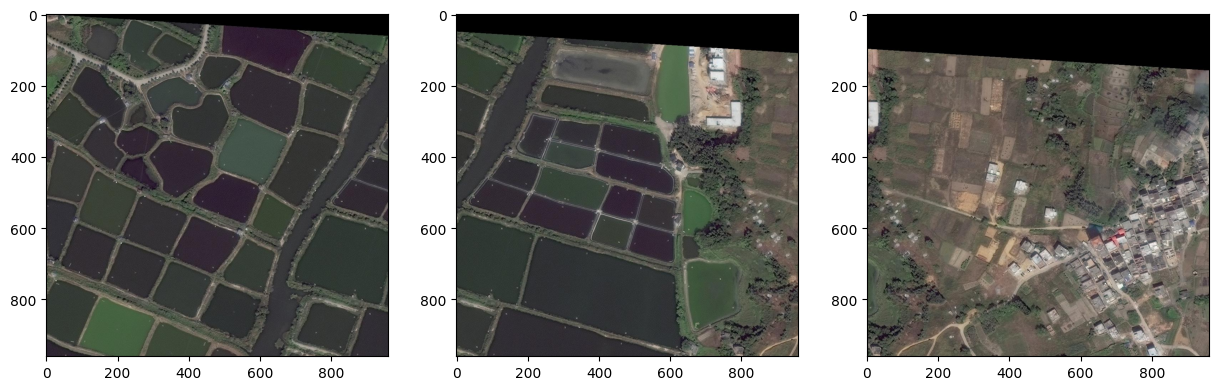

22


In [11]:
%matplotlib inline

# Create tiles using the t1 tiling code. This uses CPU to create views onto the
# original array.
import cv2
from matplotlib import pyplot as plt
import tiling

tiles = tiling.tile_image(sat_array, 960, 960, 0.2)
f,ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].imshow(tiles[i].tile)
plt.show()
for idx, tile in enumerate(tiles):
    if tile.y > 0:
        print(idx)
        break

In [23]:
# Send the sat tensor to the GPU and confirm that it arrived safely.
import torch

cuda_sat_tensor = sat_tensor.to(device).detach()
print("tensor on cuda: ", cuda_sat_tensor.shape, cuda_sat_tensor.get_device() == 0)

tensor on cuda:  torch.Size([15348, 16384, 3]) True


In [24]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   2491 MiB |   2824 MiB |   4635 MiB |   2143 MiB |
|       from large pool |   2491 MiB |   2824 MiB |   4635 MiB |   2143 MiB |
|       from small pool |      0 MiB |      0 MiB |      0 MiB |      0 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   2491 MiB |   2824 MiB |   4635 MiB |   2143 MiB |
|       from large pool |   2491 MiB |   2824 MiB |   4635 MiB |

In [30]:
chw = cuda_sat_tensor.permute(2, 0, 1)
unfolded = chw.unfold(1, size, stride).unfold(2, size, stride)
hwc = unfolded.permute(1, 2, 3, 4, 0)
print(hwc.shape)
batches = hwc.reshape(hwc.shape[0] * hwc.shape[1], hwc.shape[2], hwc.shape[3], hwc.shape[4])

torch.Size([19, 21, 960, 960, 3])


In [31]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1771 MiB |   2824 MiB |   5703 MiB |   3931 MiB |
|       from large pool |   1771 MiB |   2824 MiB |   5703 MiB |   3931 MiB |
|       from small pool |      0 MiB |      0 MiB |      0 MiB |      0 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   1771 MiB |   2824 MiB |   5703 MiB |   3931 MiB |
|       from large pool |   1771 MiB |   2824 MiB |   5703 MiB |

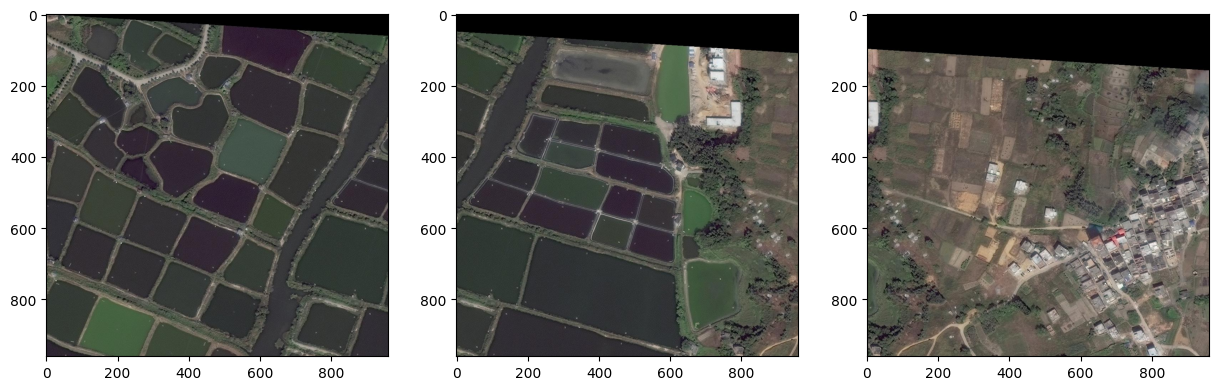

In [33]:
f,ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    patch = batches[i, :, :, :].cpu().to(dtype=torch.uint8).numpy()
    ax[i].imshow(patch)

In [29]:
print(hwc.shape)

torch.Size([19, 21, 960, 960, 3])


## Benchmarking Comparisons
This attempts to use torch profiling to compare the improvement between using the unfolded views for inference vs. image tiling in code.

In [10]:
from transformers import Owlv2Processor, Owlv2ImageProcessor, Owlv2ForObjectDetection, OwlViTProcessor, OwlViTForObjectDetection
from torch.profiler import profile, record_function, ProfilerActivity
import torch

processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

# processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
# model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

text_queries = ["ship from the point of view of a satellite"]

### Benchmark Manual Tiling

In [3]:
%%time

import tiling
import tqdm
from torch.profiler import profile, record_function, ProfilerActivity

with torch.profiler.profile(
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/manual_inference'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
) as prof:
    with record_function("manual_inference"):
        model.to(device)
        tiles = tiling.tile_image(sat_array, size, size, 0.2)
        target_sizes = torch.Tensor([1, size, size])
        results = []
        for tile in tqdm.tqdm(tiles):
            inputs = processor(text=text_queries, images=tile.tile, return_tensors="pt")
            inputs.to(device)
            with torch.no_grad():
                outputs = model(**inputs)
                results.append(processor.post_process_object_detection(
                    outputs=outputs,
                    target_sizes=[(size, size)])[0])
            prof.step()

STAGE:2024-02-09 03:34:55 301:301 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
[W CPUAllocator.cpp:235] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 440/440 [03:01<00:00,  2.42it/s]
STAGE:2024-02-09 03:38:05 301:301 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-02-09 03:38:06 301:301 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


CPU times: user 5min 41s, sys: 7.59 s, total: 5min 49s
Wall time: 5min 14s


### Benchmark GPU Tiling

The following pre-processing steps are taken from the [OwlV2ImageProcessor](https://github.com/huggingface/transformers/blob/main/src/transformers/models/owlv2/image_processing_owlv2.py) and the [corresponding config](https://huggingface.co/google/owlv2-base-patch16-ensemble/blob/main/preprocessor_config.json).

In [11]:
from torchvision.transforms import v2

def convert_nhwc_to_nchw(batch):
    return batch.permute(0, 3, 1, 2)

image_mean = [
    0.48145466,
    0.4578275,
    0.40821073
]
image_std = [
    0.26862954,
    0.26130258,
    0.27577711
]
def normalize(batch):
    return v2.functional.normalize(batch, mean=image_mean, std=image_std, inplace=True)

rescale_factor = 0.00392156862745098
def rescale(batch):
    return batch * rescale_factor

In [ ]:
%%time
import tqdm
import torch

with torch.profiler.profile(
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/gpu_inference'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
) as prof:
    with record_function("gpu_inference"):
        with torch.no_grad():
            cuda_sat_tensor = sat_tensor.to(device).detach()
            chw = cuda_sat_tensor.permute(2, 0, 1)
            unfolded = chw.unfold(1, size, stride).unfold(2, size, stride)
            hwc = unfolded.permute(1, 2, 3, 4, 0)
            batches = hwc.reshape(hwc.shape[0] * hwc.shape[1], hwc.shape[2], hwc.shape[3], hwc.shape[4])
            batches = normalize(rescale(convert_nhwc_to_nchw(batches)))
            iterations = int(batches.shape[0] / 5)
            results = []
            inputs = processor(text=text_queries, return_tensors="pt").to(device)
            attention_mask = inputs['attention_mask'].repeat(5, 1)
            input_ids = inputs['input_ids'].repeat(5, 1)
            model.to(device)
            for i in tqdm.tqdm(range(iterations)):
                images = batches[i * 5:i * 5 + 5]
                inputs['pixel_values'] = images
                inputs['attention_mask'] = attention_mask[:images.shape[0]]
                inputs['input_ids'] = input_ids[:images.shape[0]]
                results.extend(model(**inputs))
                prof.step()

STAGE:2024-02-09 03:40:53 421:421 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
[W CPUAllocator.cpp:235] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event


79


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [02:04<00:00,  1.57s/it]
STAGE:2024-02-09 03:42:59 421:421 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-02-09 03:42:59 421:421 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [15]:
%%time
import tqdm
import torch

batch_size = 1

torch.set_float32_matmul_precision('high')
with torch.no_grad():
    cuda_sat_tensor = sat_tensor.to(device).detach()
    chw = cuda_sat_tensor.permute(2, 0, 1)
    unfolded = chw.unfold(1, size, size).unfold(2, size, size)
    hwc = unfolded.permute(1, 2, 3, 4, 0)
    batches = hwc.reshape(hwc.shape[0] * hwc.shape[1], hwc.shape[2], hwc.shape[3], hwc.shape[4])
    batches = normalize(rescale(convert_nhwc_to_nchw(batches)))
    iterations = int(batches.shape[0] / batch_size)
    results = []
    inputs = processor(text=text_queries, return_tensors="pt").to(device)
    attention_mask = inputs['attention_mask'].repeat(batch_size, 1)
    input_ids = inputs['input_ids'].repeat(batch_size, 1)
    model.to(device)
    for i in tqdm.tqdm(range(iterations)):
        images = batches[i * batch_size:i * batch_size + batch_size]
        inputs['pixel_values'] = images
        inputs['attention_mask'] = attention_mask[:images.shape[0]]
        inputs['input_ids'] = input_ids[:images.shape[0]]
        results.extend(model(**inputs, output_attentions=False, output_hidden_states=False))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]

CPU times: user 1.55 s, sys: 7.82 ms, total: 1.55 s
Wall time: 1.55 s


In [12]:
__version__

NameError: name '__version__' is not defined